# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [31]:
from cs231n.features import *

num_color_bins = 35 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [21]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#reshape data to rows#####
print(X_train_feats.shape)
X_train_feats = np.reshape(X_train_feats, (X_train_feats.shape[0], -1))
X_val_feats = np.reshape(X_val_feats, (X_val_feats.shape[0], -1))
X_test_feats = np.reshape(X_test_feats, (X_test_feats.shape[0], -1))
###########################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        print(X_train_feats.shape)
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,num_iters=1200, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)]=(training_accuracy,validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm=svm
            
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

(49000, 180)
(49000, 180)
iteration 0 / 1200: loss 98.995591
iteration 100 / 1200: loss 97.219535
iteration 200 / 1200: loss 95.467910
iteration 300 / 1200: loss 93.754868
iteration 400 / 1200: loss 92.087847
iteration 500 / 1200: loss 90.422820
iteration 600 / 1200: loss 88.824633
iteration 700 / 1200: loss 87.232569
iteration 800 / 1200: loss 85.693769
iteration 900 / 1200: loss 84.165148
iteration 1000 / 1200: loss 82.695049
iteration 1100 / 1200: loss 81.222173
(49000, 180)
iteration 0 / 1200: loss 881.763555
iteration 100 / 1200: loss 723.477340
iteration 200 / 1200: loss 593.910953
iteration 300 / 1200: loss 487.823923
iteration 400 / 1200: loss 400.978921
iteration 500 / 1200: loss 329.902057
iteration 600 / 1200: loss 271.704483
iteration 700 / 1200: loss 224.061296
iteration 800 / 1200: loss 185.056400
iteration 900 / 1200: loss 153.138928
iteration 1000 / 1200: loss 126.987513
iteration 1100 / 1200: loss 105.596770
(49000, 180)
iteration 0 / 1200: loss 9158.873351
iteration 1

In [22]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.416


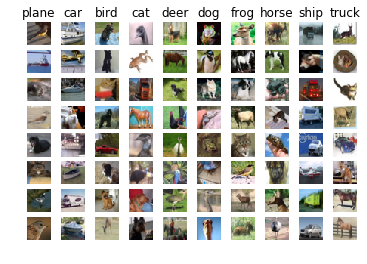

In [23]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$
plane classification has many bird images which makes sense as they have a similar body shapes so perhaps the HOG features were similar for the two

Many ships have been classified as car that have a black shadow beneath them which could correspond to black color of car wheels. So this also makes sense in that way. Also, blue color of the sea is not that prominent in this diagram, making it less obvious to classifier that this is a ship.



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [32]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 180)
(49000, 179)


[1.00000000e-10 3.16227766e-08 1.00000000e-05 3.16227766e-03
 1.00000000e+00] [1.e-03 1.e-01 1.e+01 1.e+03 1.e+05]
iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 2.302586
iteration 200 / 2000: loss 2.302586
iteration 300 / 2000: loss 2.302586
iteration 400 / 2000: loss 2.302585
iteration 500 / 2000: loss 2.302585
iteration 600 / 2000: loss 2.302586
iteration 700 / 2000: loss 2.302586
iteration 800 / 2000: loss 2.302585
iteration 900 / 2000: loss 2.302586
iteration 1000 / 2000: loss 2.302585
iteration 1100 / 2000: loss 2.302585
iteration 1200 / 2000: loss 2.302585
iteration 1300 / 2000: loss 2.302586
iteration 1400 / 2000: loss 2.302585
iteration 1500 / 2000: loss 2.302586
iteration 1600 / 2000: loss 2.302586
iteration 1700 / 2000: loss 2.302586
iteration 1800 / 2000: loss 2.302585
iteration 1900 / 2000: loss 2.302585


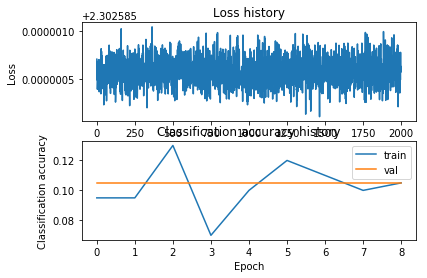

iteration 0 / 2000: loss 2.302633
iteration 100 / 2000: loss 2.302633
iteration 200 / 2000: loss 2.302633
iteration 300 / 2000: loss 2.302633
iteration 400 / 2000: loss 2.302633
iteration 500 / 2000: loss 2.302633
iteration 600 / 2000: loss 2.302633
iteration 700 / 2000: loss 2.302633
iteration 800 / 2000: loss 2.302632
iteration 900 / 2000: loss 2.302633
iteration 1000 / 2000: loss 2.302633
iteration 1100 / 2000: loss 2.302633
iteration 1200 / 2000: loss 2.302633
iteration 1300 / 2000: loss 2.302633
iteration 1400 / 2000: loss 2.302633
iteration 1500 / 2000: loss 2.302633
iteration 1600 / 2000: loss 2.302633
iteration 1700 / 2000: loss 2.302632
iteration 1800 / 2000: loss 2.302633
iteration 1900 / 2000: loss 2.302633


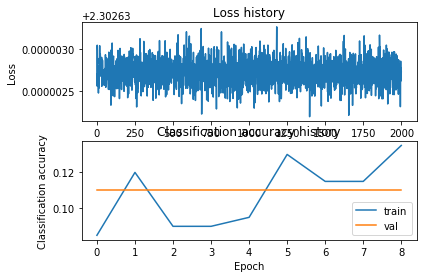

iteration 0 / 2000: loss 2.307306
iteration 100 / 2000: loss 2.307306
iteration 200 / 2000: loss 2.307305
iteration 300 / 2000: loss 2.307305
iteration 400 / 2000: loss 2.307306
iteration 500 / 2000: loss 2.307306
iteration 600 / 2000: loss 2.307305
iteration 700 / 2000: loss 2.307306
iteration 800 / 2000: loss 2.307306
iteration 900 / 2000: loss 2.307306
iteration 1000 / 2000: loss 2.307306
iteration 1100 / 2000: loss 2.307305
iteration 1200 / 2000: loss 2.307306
iteration 1300 / 2000: loss 2.307306
iteration 1400 / 2000: loss 2.307305
iteration 1500 / 2000: loss 2.307305
iteration 1600 / 2000: loss 2.307306
iteration 1700 / 2000: loss 2.307305
iteration 1800 / 2000: loss 2.307306
iteration 1900 / 2000: loss 2.307305


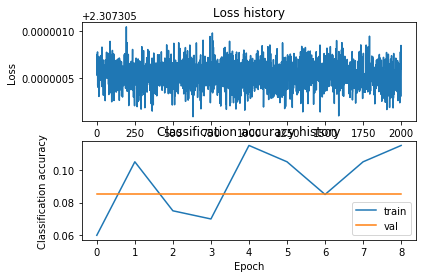

iteration 0 / 2000: loss 2.778623
iteration 100 / 2000: loss 2.778614
iteration 200 / 2000: loss 2.778604
iteration 300 / 2000: loss 2.778596
iteration 400 / 2000: loss 2.778587
iteration 500 / 2000: loss 2.778579
iteration 600 / 2000: loss 2.778570
iteration 700 / 2000: loss 2.778562
iteration 800 / 2000: loss 2.778554
iteration 900 / 2000: loss 2.778547
iteration 1000 / 2000: loss 2.778539
iteration 1100 / 2000: loss 2.778532
iteration 1200 / 2000: loss 2.778524
iteration 1300 / 2000: loss 2.778517
iteration 1400 / 2000: loss 2.778510
iteration 1500 / 2000: loss 2.778503
iteration 1600 / 2000: loss 2.778496
iteration 1700 / 2000: loss 2.778490
iteration 1800 / 2000: loss 2.778483
iteration 1900 / 2000: loss 2.778477


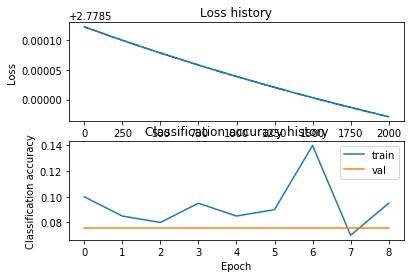

iteration 0 / 2000: loss 49.594736
iteration 100 / 2000: loss 49.504919
iteration 200 / 2000: loss 49.415319
iteration 300 / 2000: loss 49.328302
iteration 400 / 2000: loss 49.243497
iteration 500 / 2000: loss 49.159225
iteration 600 / 2000: loss 49.078946
iteration 700 / 2000: loss 48.998804
iteration 800 / 2000: loss 48.921359
iteration 900 / 2000: loss 48.845477
iteration 1000 / 2000: loss 48.770439
iteration 1100 / 2000: loss 48.698582
iteration 1200 / 2000: loss 48.626837
iteration 1300 / 2000: loss 48.557851
iteration 1400 / 2000: loss 48.489897
iteration 1500 / 2000: loss 48.423026
iteration 1600 / 2000: loss 48.358656
iteration 1700 / 2000: loss 48.294375
iteration 1800 / 2000: loss 48.232878
iteration 1900 / 2000: loss 48.171976


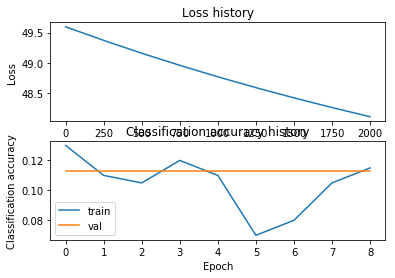

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302586
iteration 200 / 2000: loss 2.302586
iteration 300 / 2000: loss 2.302586
iteration 400 / 2000: loss 2.302586
iteration 500 / 2000: loss 2.302585
iteration 600 / 2000: loss 2.302586
iteration 700 / 2000: loss 2.302585
iteration 800 / 2000: loss 2.302585
iteration 900 / 2000: loss 2.302586
iteration 1000 / 2000: loss 2.302586
iteration 1100 / 2000: loss 2.302586
iteration 1200 / 2000: loss 2.302586
iteration 1300 / 2000: loss 2.302585
iteration 1400 / 2000: loss 2.302586
iteration 1500 / 2000: loss 2.302586
iteration 1600 / 2000: loss 2.302586
iteration 1700 / 2000: loss 2.302586
iteration 1800 / 2000: loss 2.302586
iteration 1900 / 2000: loss 2.302586


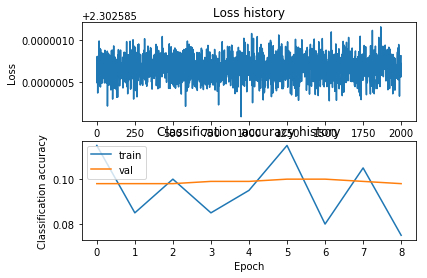

iteration 0 / 2000: loss 2.302632
iteration 100 / 2000: loss 2.302633
iteration 200 / 2000: loss 2.302632
iteration 300 / 2000: loss 2.302633
iteration 400 / 2000: loss 2.302633
iteration 500 / 2000: loss 2.302633
iteration 600 / 2000: loss 2.302633
iteration 700 / 2000: loss 2.302633
iteration 800 / 2000: loss 2.302633
iteration 900 / 2000: loss 2.302633
iteration 1000 / 2000: loss 2.302633
iteration 1100 / 2000: loss 2.302633
iteration 1200 / 2000: loss 2.302633
iteration 1300 / 2000: loss 2.302633
iteration 1400 / 2000: loss 2.302633
iteration 1500 / 2000: loss 2.302633
iteration 1600 / 2000: loss 2.302633
iteration 1700 / 2000: loss 2.302633
iteration 1800 / 2000: loss 2.302633
iteration 1900 / 2000: loss 2.302633


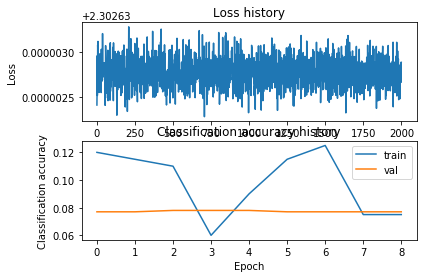

iteration 0 / 2000: loss 2.307291
iteration 100 / 2000: loss 2.307291
iteration 200 / 2000: loss 2.307290
iteration 300 / 2000: loss 2.307290
iteration 400 / 2000: loss 2.307290
iteration 500 / 2000: loss 2.307290
iteration 600 / 2000: loss 2.307290
iteration 700 / 2000: loss 2.307289
iteration 800 / 2000: loss 2.307289
iteration 900 / 2000: loss 2.307288
iteration 1000 / 2000: loss 2.307288
iteration 1100 / 2000: loss 2.307288
iteration 1200 / 2000: loss 2.307288
iteration 1300 / 2000: loss 2.307288
iteration 1400 / 2000: loss 2.307288
iteration 1500 / 2000: loss 2.307287
iteration 1600 / 2000: loss 2.307287
iteration 1700 / 2000: loss 2.307287
iteration 1800 / 2000: loss 2.307287
iteration 1900 / 2000: loss 2.307287


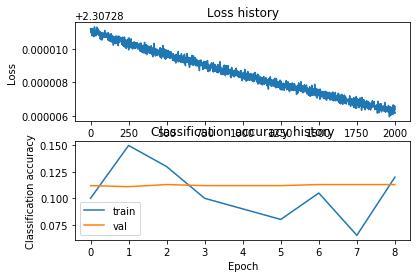

iteration 0 / 2000: loss 2.775519
iteration 100 / 2000: loss 2.772684
iteration 200 / 2000: loss 2.769868
iteration 300 / 2000: loss 2.767144
iteration 400 / 2000: loss 2.764500
iteration 500 / 2000: loss 2.761883
iteration 600 / 2000: loss 2.759399
iteration 700 / 2000: loss 2.756929
iteration 800 / 2000: loss 2.754550
iteration 900 / 2000: loss 2.752228
iteration 1000 / 2000: loss 2.749939
iteration 1100 / 2000: loss 2.747755
iteration 1200 / 2000: loss 2.745582
iteration 1300 / 2000: loss 2.743499
iteration 1400 / 2000: loss 2.741454
iteration 1500 / 2000: loss 2.739448
iteration 1600 / 2000: loss 2.737522
iteration 1700 / 2000: loss 2.735606
iteration 1800 / 2000: loss 2.733778
iteration 1900 / 2000: loss 2.731972


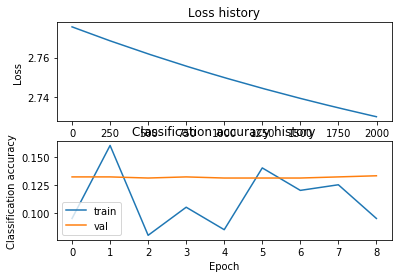

iteration 0 / 2000: loss 49.456400
iteration 100 / 2000: loss 28.128040
iteration 200 / 2000: loss 16.451297
iteration 300 / 2000: loss 10.181236
iteration 400 / 2000: loss 6.751007
iteration 500 / 2000: loss 4.820719
iteration 600 / 2000: loss 3.765645
iteration 700 / 2000: loss 3.152637
iteration 800 / 2000: loss 2.805141
iteration 900 / 2000: loss 2.602622
iteration 1000 / 2000: loss 2.482594
iteration 1100 / 2000: loss 2.412865
iteration 1200 / 2000: loss 2.370147
iteration 1300 / 2000: loss 2.344734
iteration 1400 / 2000: loss 2.329048
iteration 1500 / 2000: loss 2.319313
iteration 1600 / 2000: loss 2.313335
iteration 1700 / 2000: loss 2.309494
iteration 1800 / 2000: loss 2.307108
iteration 1900 / 2000: loss 2.305557


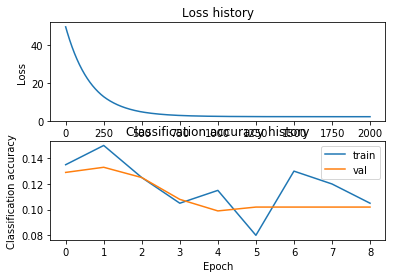

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 2.302586
iteration 200 / 2000: loss 2.302586
iteration 300 / 2000: loss 2.302586
iteration 400 / 2000: loss 2.302585
iteration 500 / 2000: loss 2.302586
iteration 600 / 2000: loss 2.302585
iteration 700 / 2000: loss 2.302585
iteration 800 / 2000: loss 2.302585
iteration 900 / 2000: loss 2.302585
iteration 1000 / 2000: loss 2.302586
iteration 1100 / 2000: loss 2.302586
iteration 1200 / 2000: loss 2.302586
iteration 1300 / 2000: loss 2.302586
iteration 1400 / 2000: loss 2.302586
iteration 1500 / 2000: loss 2.302586
iteration 1600 / 2000: loss 2.302586
iteration 1700 / 2000: loss 2.302586
iteration 1800 / 2000: loss 2.302585
iteration 1900 / 2000: loss 2.302585


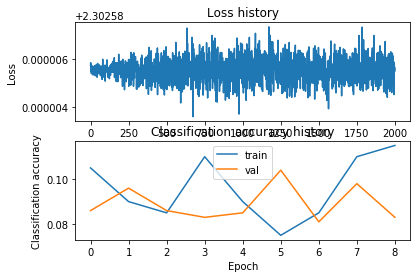

iteration 0 / 2000: loss 2.302632
iteration 100 / 2000: loss 2.302632
iteration 200 / 2000: loss 2.302632
iteration 300 / 2000: loss 2.302632
iteration 400 / 2000: loss 2.302632
iteration 500 / 2000: loss 2.302632
iteration 600 / 2000: loss 2.302632
iteration 700 / 2000: loss 2.302632
iteration 800 / 2000: loss 2.302632
iteration 900 / 2000: loss 2.302632
iteration 1000 / 2000: loss 2.302632
iteration 1100 / 2000: loss 2.302632
iteration 1200 / 2000: loss 2.302631
iteration 1300 / 2000: loss 2.302632
iteration 1400 / 2000: loss 2.302632
iteration 1500 / 2000: loss 2.302632
iteration 1600 / 2000: loss 2.302632
iteration 1700 / 2000: loss 2.302631
iteration 1800 / 2000: loss 2.302632
iteration 1900 / 2000: loss 2.302632


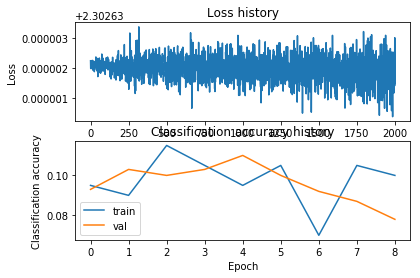

iteration 0 / 2000: loss 2.307372
iteration 100 / 2000: loss 2.307282
iteration 200 / 2000: loss 2.307193
iteration 300 / 2000: loss 2.307108
iteration 400 / 2000: loss 2.307028
iteration 500 / 2000: loss 2.306949
iteration 600 / 2000: loss 2.306875
iteration 700 / 2000: loss 2.306801
iteration 800 / 2000: loss 2.306732
iteration 900 / 2000: loss 2.306666
iteration 1000 / 2000: loss 2.306600
iteration 1100 / 2000: loss 2.306538
iteration 1200 / 2000: loss 2.306478
iteration 1300 / 2000: loss 2.306420
iteration 1400 / 2000: loss 2.306364
iteration 1500 / 2000: loss 2.306310
iteration 1600 / 2000: loss 2.306258
iteration 1700 / 2000: loss 2.306208
iteration 1800 / 2000: loss 2.306159
iteration 1900 / 2000: loss 2.306112


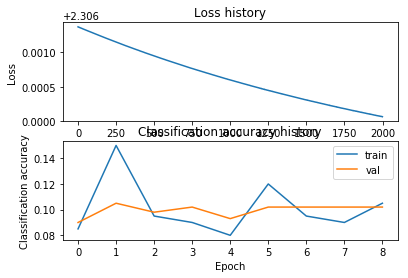

iteration 0 / 2000: loss 2.773886
iteration 100 / 2000: loss 2.372369
iteration 200 / 2000: loss 2.312928
iteration 300 / 2000: loss 2.304200
iteration 400 / 2000: loss 2.302849
iteration 500 / 2000: loss 2.302628
iteration 600 / 2000: loss 2.302593
iteration 700 / 2000: loss 2.302586
iteration 800 / 2000: loss 2.302586
iteration 900 / 2000: loss 2.302584
iteration 1000 / 2000: loss 2.302586
iteration 1100 / 2000: loss 2.302585
iteration 1200 / 2000: loss 2.302585
iteration 1300 / 2000: loss 2.302585
iteration 1400 / 2000: loss 2.302586
iteration 1500 / 2000: loss 2.302585
iteration 1600 / 2000: loss 2.302585
iteration 1700 / 2000: loss 2.302585
iteration 1800 / 2000: loss 2.302584
iteration 1900 / 2000: loss 2.302586


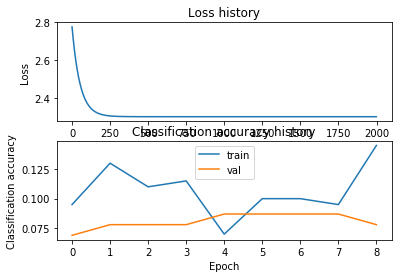

iteration 0 / 2000: loss 49.431855
iteration 100 / 2000: loss 2.302585
iteration 200 / 2000: loss 2.302585
iteration 300 / 2000: loss 2.302585
iteration 400 / 2000: loss 2.302585
iteration 500 / 2000: loss 2.302585
iteration 600 / 2000: loss 2.302584
iteration 700 / 2000: loss 2.302585
iteration 800 / 2000: loss 2.302585
iteration 900 / 2000: loss 2.302585
iteration 1000 / 2000: loss 2.302585
iteration 1100 / 2000: loss 2.302585
iteration 1200 / 2000: loss 2.302584
iteration 1300 / 2000: loss 2.302585
iteration 1400 / 2000: loss 2.302585
iteration 1500 / 2000: loss 2.302586
iteration 1600 / 2000: loss 2.302585
iteration 1700 / 2000: loss 2.302586
iteration 1800 / 2000: loss 2.302585
iteration 1900 / 2000: loss 2.302586


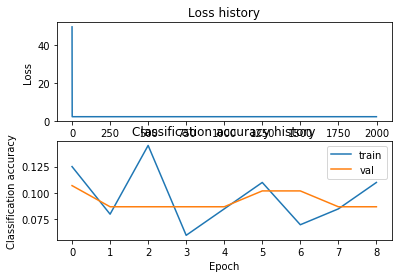

iteration 0 / 2000: loss 2.302585
iteration 100 / 2000: loss 2.302649
iteration 200 / 2000: loss 2.302511
iteration 300 / 2000: loss 2.302542
iteration 400 / 2000: loss 2.302613
iteration 500 / 2000: loss 2.302288
iteration 600 / 2000: loss 2.302543
iteration 700 / 2000: loss 2.302536
iteration 800 / 2000: loss 2.302726
iteration 900 / 2000: loss 2.302651
iteration 1000 / 2000: loss 2.302642
iteration 1100 / 2000: loss 2.302703
iteration 1200 / 2000: loss 2.302715
iteration 1300 / 2000: loss 2.302523
iteration 1400 / 2000: loss 2.302464
iteration 1500 / 2000: loss 2.302464
iteration 1600 / 2000: loss 2.302489
iteration 1700 / 2000: loss 2.302645
iteration 1800 / 2000: loss 2.302344
iteration 1900 / 2000: loss 2.302515


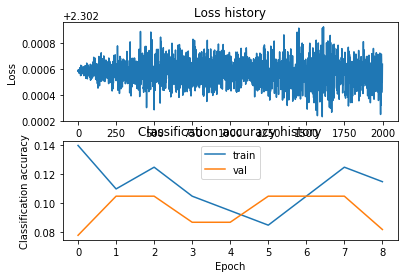

iteration 0 / 2000: loss 2.302632
iteration 100 / 2000: loss 2.302603
iteration 200 / 2000: loss 2.302675
iteration 300 / 2000: loss 2.302594
iteration 400 / 2000: loss 2.302574
iteration 500 / 2000: loss 2.302600
iteration 600 / 2000: loss 2.302806
iteration 700 / 2000: loss 2.302561
iteration 800 / 2000: loss 2.302599
iteration 900 / 2000: loss 2.302754
iteration 1000 / 2000: loss 2.302583
iteration 1100 / 2000: loss 2.302388
iteration 1200 / 2000: loss 2.302502
iteration 1300 / 2000: loss 2.302746
iteration 1400 / 2000: loss 2.302668
iteration 1500 / 2000: loss 2.302551
iteration 1600 / 2000: loss 2.302647
iteration 1700 / 2000: loss 2.302755
iteration 1800 / 2000: loss 2.302506
iteration 1900 / 2000: loss 2.302593


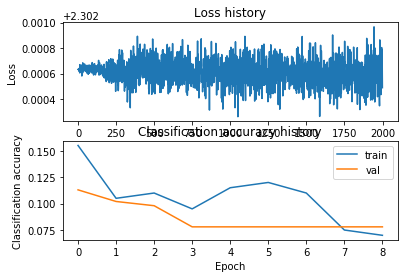

iteration 0 / 2000: loss 2.307302
iteration 100 / 2000: loss 2.302553
iteration 200 / 2000: loss 2.302644
iteration 300 / 2000: loss 2.302602
iteration 400 / 2000: loss 2.302624
iteration 500 / 2000: loss 2.302427
iteration 600 / 2000: loss 2.302620
iteration 700 / 2000: loss 2.302618
iteration 800 / 2000: loss 2.302547
iteration 900 / 2000: loss 2.302669
iteration 1000 / 2000: loss 2.302732
iteration 1100 / 2000: loss 2.302646
iteration 1200 / 2000: loss 2.302633
iteration 1300 / 2000: loss 2.302549
iteration 1400 / 2000: loss 2.302526
iteration 1500 / 2000: loss 2.302470
iteration 1600 / 2000: loss 2.302566
iteration 1700 / 2000: loss 2.302627
iteration 1800 / 2000: loss 2.302692
iteration 1900 / 2000: loss 2.302631


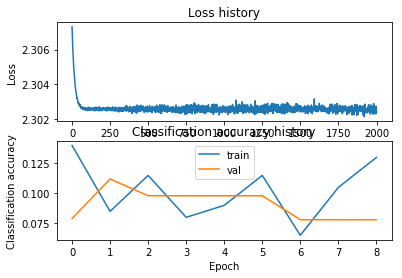

iteration 0 / 2000: loss 2.774239
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan


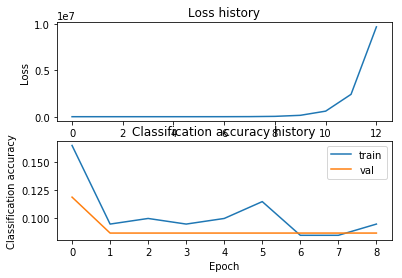

iteration 0 / 2000: loss 49.394779
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan


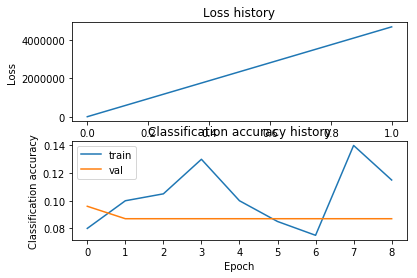

iteration 0 / 2000: loss 2.302586
iteration 100 / 2000: loss 1.386226
iteration 200 / 2000: loss 1.356261
iteration 300 / 2000: loss 1.319608
iteration 400 / 2000: loss 1.302155
iteration 500 / 2000: loss 1.241253
iteration 600 / 2000: loss 1.326502
iteration 700 / 2000: loss 1.173976
iteration 800 / 2000: loss 1.229834
iteration 900 / 2000: loss 1.213769
iteration 1000 / 2000: loss 1.258721
iteration 1100 / 2000: loss 1.099596
iteration 1200 / 2000: loss 1.108984
iteration 1300 / 2000: loss 1.120115
iteration 1400 / 2000: loss 1.066138
iteration 1500 / 2000: loss 0.935587
iteration 1600 / 2000: loss 0.970244
iteration 1700 / 2000: loss 0.987837
iteration 1800 / 2000: loss 1.079333
iteration 1900 / 2000: loss 1.215434


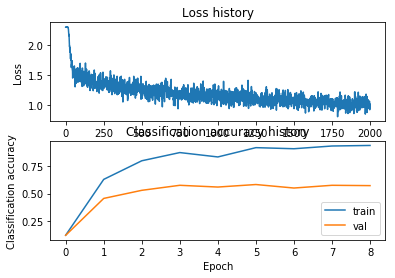

iteration 0 / 2000: loss 2.302632
iteration 100 / 2000: loss 2.070181
iteration 200 / 2000: loss 2.087593
iteration 300 / 2000: loss 1.989280
iteration 400 / 2000: loss 1.974977
iteration 500 / 2000: loss 2.064157
iteration 600 / 2000: loss 1.920646
iteration 700 / 2000: loss 1.979547
iteration 800 / 2000: loss 1.987187
iteration 900 / 2000: loss 2.023747
iteration 1000 / 2000: loss 1.926999
iteration 1100 / 2000: loss 1.973907
iteration 1200 / 2000: loss 2.000024
iteration 1300 / 2000: loss 2.069383
iteration 1400 / 2000: loss 1.939265
iteration 1500 / 2000: loss 1.953204
iteration 1600 / 2000: loss 1.945369
iteration 1700 / 2000: loss 1.931200
iteration 1800 / 2000: loss 2.045757
iteration 1900 / 2000: loss 2.066189


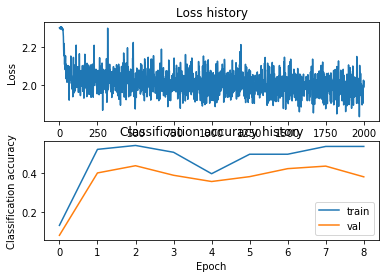

iteration 0 / 2000: loss 2.307308
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan


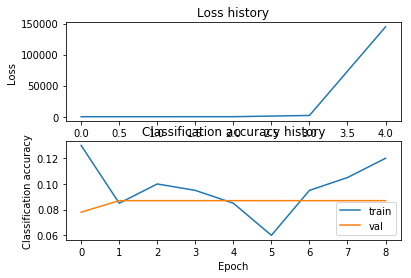

iteration 0 / 2000: loss 2.775419
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan


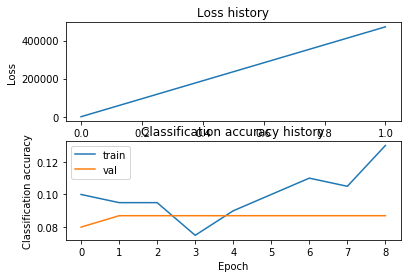

iteration 0 / 2000: loss 49.406018
iteration 100 / 2000: loss nan
iteration 200 / 2000: loss nan
iteration 300 / 2000: loss nan
iteration 400 / 2000: loss nan
iteration 500 / 2000: loss nan
iteration 600 / 2000: loss nan
iteration 700 / 2000: loss nan
iteration 800 / 2000: loss nan
iteration 900 / 2000: loss nan
iteration 1000 / 2000: loss nan
iteration 1100 / 2000: loss nan
iteration 1200 / 2000: loss nan
iteration 1300 / 2000: loss nan
iteration 1400 / 2000: loss nan
iteration 1500 / 2000: loss nan
iteration 1600 / 2000: loss nan
iteration 1700 / 2000: loss nan
iteration 1800 / 2000: loss nan
iteration 1900 / 2000: loss nan


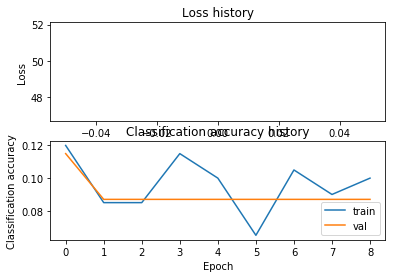

lr 1.000000e-10 reg 1.000000e-03 train accuracy: 0.103980 val accuracy: 0.105000
lr 1.000000e-10 reg 1.000000e-01 train accuracy: 0.107143 val accuracy: 0.110000
lr 1.000000e-10 reg 1.000000e+01 train accuracy: 0.080857 val accuracy: 0.085000
lr 1.000000e-10 reg 1.000000e+03 train accuracy: 0.088429 val accuracy: 0.076000
lr 1.000000e-10 reg 1.000000e+05 train accuracy: 0.105939 val accuracy: 0.113000
lr 3.162278e-08 reg 1.000000e-03 train accuracy: 0.092653 val accuracy: 0.099000
lr 3.162278e-08 reg 1.000000e-01 train accuracy: 0.085347 val accuracy: 0.077000
lr 3.162278e-08 reg 1.000000e+01 train accuracy: 0.102184 val accuracy: 0.113000
lr 3.162278e-08 reg 1.000000e+03 train accuracy: 0.111286 val accuracy: 0.134000
lr 3.162278e-08 reg 1.000000e+05 train accuracy: 0.099959 val accuracy: 0.102000
lr 1.000000e-05 reg 1.000000e-03 train accuracy: 0.107796 val accuracy: 0.081000
lr 1.000000e-05 reg 1.000000e-01 train accuracy: 0.100592 val accuracy: 0.078000
lr 1.000000e-05 reg 1.000000

In [49]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10
results={}
best_val = -1
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = np.logspace(-10, 0, 5) # np.logspace(-10, 10, 8) #-10, -9, -8, -7, -6, -5, -4
regularization_strengths = np.logspace(-3, 5, 5) # causes numeric issues: np.logspace(-5, 5, 8) #[-4, -3, -2, -1, 1, 2, 3, 4, 5, 6]
num_classes = 10
print(learning_rates,regularization_strengths)
for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
            num_iters=2000,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=reg, verbose=True)
        # Plot the loss function and train / validation accuracies
        plt.subplot(2, 1, 1)
        plt.plot(stats['loss_history'])
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(stats['train_acc_history'], label='train')
        plt.plot(stats['val_acc_history'], label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Classification accuracy')
        plt.legend()
        plt.show()

        y_train_pred = net.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = net.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(lr,reg)]=(training_accuracy,validation_accuracy)
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [50]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.
print(best_net)
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.558
